# Filters

There are four basic types of filters: low-pass, high-pass, band-pass, and band-stop. Each type modifies signals to focus on different ranges of frequencies within them. The plots below demonstrate how frequencies in signals are filtered for each type, presented first with just positive frequencies (easier to understand), then also including negative. Negative frequencies must not be considered because SDRs operate with negative frequencies.

![Alt text](https://pysdr.org/_images/filter_types.png)

![Alt text](https://pysdr.org/_images/tikz-e3aaf5f7c52c87ef9c6da68e8d840ca469e0b53d.svg)

![Alt text](https://pysdr.org/_images/tikz-f88ddd43f673a3ba2436438aa4b2b983f124db7a.svg)

![Alt text](https://pysdr.org/_images/tikz-dc783ab4a1ffd65ac8cb37d787674c288a7566e3.svg)

![Alt text](https://pysdr.org/_images/tikz-76b48577e5a767cb55f861dafb7dcb48c1718257.svg)

An example of creating a filter:

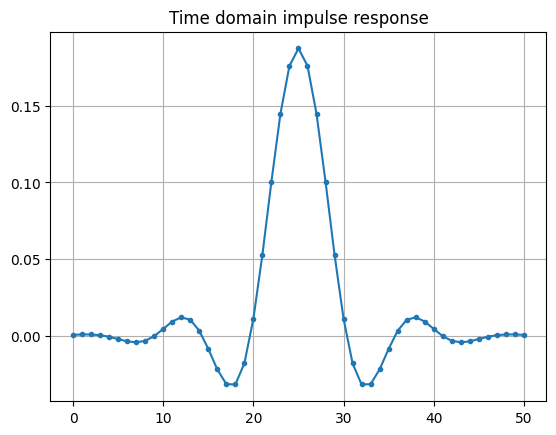

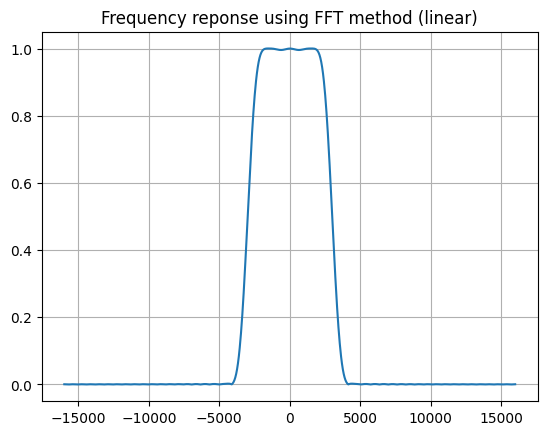

<Figure size 640x480 with 0 Axes>

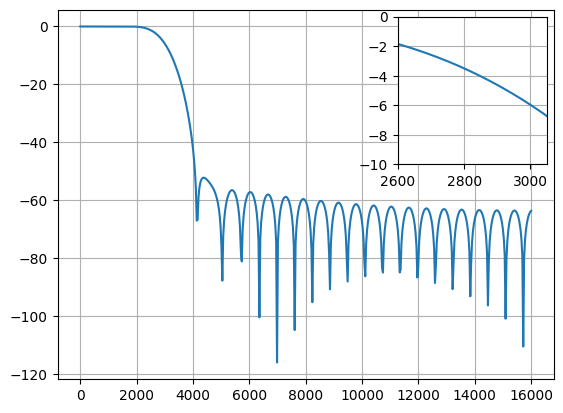

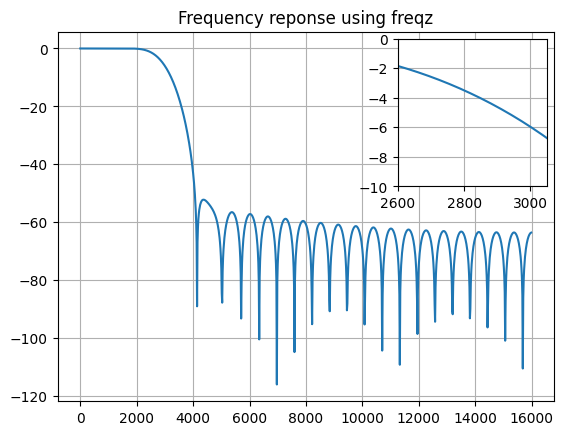

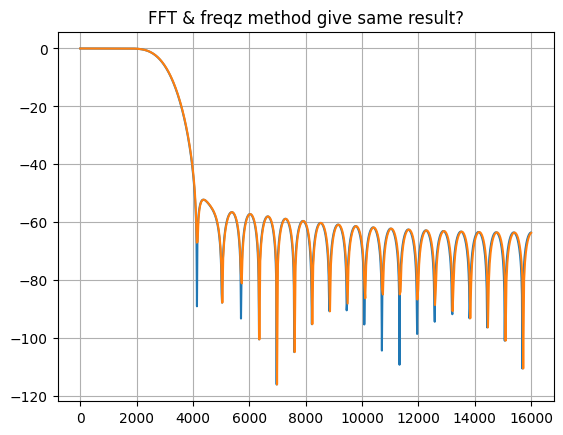

In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Odd number of taps for FIR type 1 filter
num_taps = 51 
cut_off = 3000 # Hz
sample_rate = 32000 # Hz
nyq_freq = sample_rate/2.0

# create our low pass filter
# Hamming window is default
h = signal.firwin(num_taps, cut_off/nyq_freq)

# Plot the impulse response
plt.figure(1)
plt.grid(True)
plt.title("Time domain impulse response")
plt.plot(h, '.-')

# Plot the frequency response using FFT
plt.figure(2)
H = np.fft.fftshift(np.fft.fft(h, 1024))
f = np.linspace(-sample_rate/2, sample_rate/2, len(H)) # x axis
plt.grid(True)
plt.title("Frequency reponse using FFT method (linear)")
plt.plot(f, abs(H), '-')

plt.figure(3)
H = np.abs(H[len(H)//2:])
fig, ax = plt.subplots()
w = np.linspace(0, sample_rate/2, len(H))
H_db = 20*np.log10(H)
plt.plot(w, H_db)
plt.grid(True)

axins = inset_axes(ax, width="30%", height="40%")
plt.grid(True)
plt.xlim(2600,3050)
plt.ylim(-10.0, 0)
plt.plot(w, H_db, '-')

# Plot the frequency response using freqz
plt.figure(4)
q, v = signal.freqz(h, worN = 1024)
fig, ax = plt.subplots()
plt.title("Frequency reponse using freqz")
plt.plot((q/np.pi)*nyq_freq, 20*np.log10(abs(v)))
plt.grid(True)

axins = inset_axes(ax, width="30%", height="40%")
plt.grid(True)
plt.xlim(2600,3050)
plt.ylim(-10.0, 0)
plt.plot(w, H_db, '-')
plt.show()

plt.figure(5)
plt.plot((q/np.pi)*nyq_freq, 20*np.log10(abs(v)))
plt.plot(w, H_db)
plt.grid(True)
plt.title("FFT & freqz method give same result?")
plt.show()


# Real vs. Complex Filters

As an example of complex taps, let’s go back to the filtering use-case, except this time we want to receive the other interfering signal (without having to re-tune the radio). That means we want a band-pass filter, but not a symmetrical one. We only want to keep (a.k.a “pass”) frequencies between around 7 kHz to 13 kHz (we don’t want to also pass -13 kHz to -7 kHz):

![Alt text](https://pysdr.org/_images/filter_use_case6.png)

One way to design this kind of filter is to make a low-pass filter with a cutoff of 3 kHz and then frequency shift it. Remember that we can frequency shift x(t) (time domain) by multiplying it by e^{j2\pi f_0t}. In this case f_0 should be 10 kHz, which shifts our filter up by 10 kHz. Recall that in our Python code from above, h was the filter taps of the low-pass filter. In order to create our band-pass filter we just have to multiply those taps by e^{j2\pi f_0t}, although it involves creating a vector to represent time based on our sample period (inverse of the sample rate):

<Figure size 640x480 with 0 Axes>

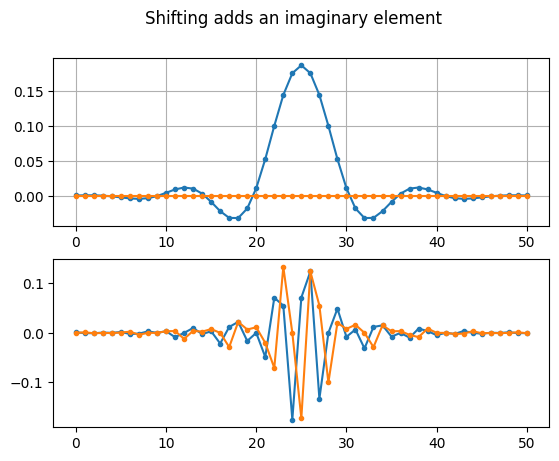

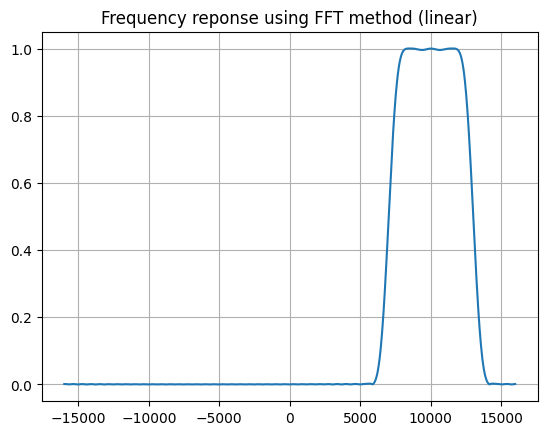

<Figure size 640x480 with 0 Axes>

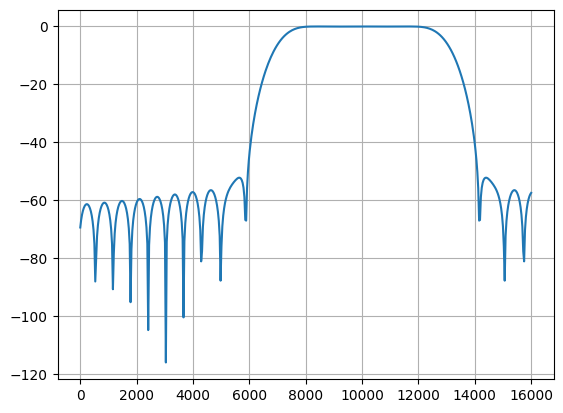

In [8]:
# h was found above
f_shift = 10e3
Ts = 1/sample_rate
t = np.arange(0, Ts*len(h), Ts)
w = 2*np.pi*f_shift
exp_shift = np.exp(1j*w*t) # this is essentially a complex cos wave

# Shift
h_band_pass = h*exp_shift

# Plot the impulse response
plt.figure(1)
fig, (ax1, ax2) = plt.subplots(2)
ax1.grid(True)
fig.suptitle("Shifting adds an imaginary element")
ax1.plot(np.real(h), '.-')
ax1.plot(np.imag(h), '.-')
ax2.plot(np.real(h_band_pass), '.-')
ax2.plot(np.imag(h_band_pass), '.-')
plt.show()

# Plot the frequency response using FFT
plt.figure(2)
H = np.fft.fftshift(np.fft.fft(h_band_pass, 1024))
f = np.linspace(-sample_rate/2, sample_rate/2, len(H)) # x axis
plt.grid(True)
plt.title("Frequency reponse using FFT method (linear)")
plt.plot(f, abs(H), '-')

plt.figure(3)
H = np.abs(H[len(H)//2:])
fig, ax = plt.subplots()
w = np.linspace(0, sample_rate/2, len(H))
H_db = 20*np.log10(H)
plt.plot(w, H_db)
plt.grid(True)
plt.show()


Because our filter is not symmetrical around 0 Hz, it has to use complex taps. Therefore we need two lines to plot those complex taps. What we see in the left-hand plot above is still the impulse response. Our frequency response plot is what really validates that we created the kind of filter we were hoping for, where it will filter out everything except the signal centered around 10 kHz. Once again, remember that the plot above is not an actual signal: it’s just a representation of the filter. It can be very confusing to grasp because when you apply the filter to the signal and plot the output in the frequency domain, in many cases it will look roughly the same as the filter’s frequency response itself.

If this subsection added to the confusion, don’t worry, 99% of the time you’ll be dealing with simple low pass filters with real taps anyway.

# Custom Filter Design

 we will use the method of starting in the frequency domain and working backwards to find the impulse response. Ultimately that is how our filter is represented (by its taps).

You start by creating a vector of your desired frequency response. Let’s design an arbitrarily shaped low-pass filter shown below:

![Alt text](https://pysdr.org/_images/filter_design1.png)

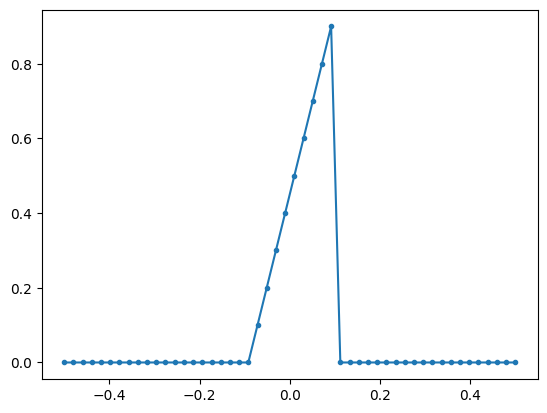

In [9]:
H = np.hstack( (np.zeros(20), np.arange(0, 1, 0.1), np.zeros(20)) )
w = np.linspace(-0.5, 0.5, 50)
plt.plot(w, H, '.-')
plt.show()

Our end goal is to find the taps of this filter so we can actually use it. How do we get the taps, given the frequency response? Well, how do we convert from the frequency domain back to the time domain? Inverse FFT (IFFT)! Recall that the IFFT function is almost exactly the same as the FFT function. We also need to IFFTshift our desired frequency response before the IFFT, and then we need yet another IFFshift after the IFFT (no, they don’t cancel themselves out, you can try). This process might seem confusing. __Just remember that you always should FFTshift after an FFT and IFFshift after an IFFT.__

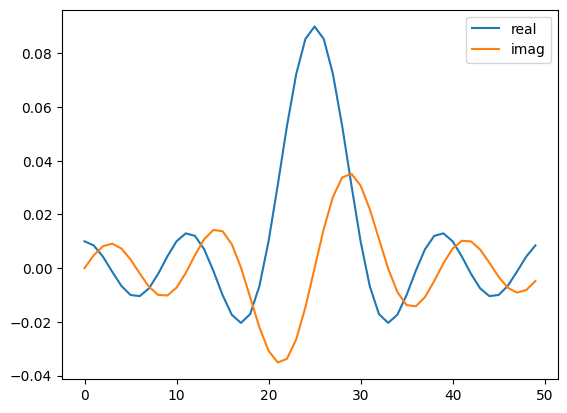

In [10]:
h = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(H)))
plt.plot(np.real(h))
plt.plot(np.imag(h))
plt.legend(['real','imag'], loc=1)
plt.show()

We will use these taps shown above as our filter. We know that the impulse response is plotting the taps, so what we see above is our impulse response. Let’s take the FFT of our taps to see what the frequency domain actually looks like. We will do a 1,024 point FFT to get a high resolution:

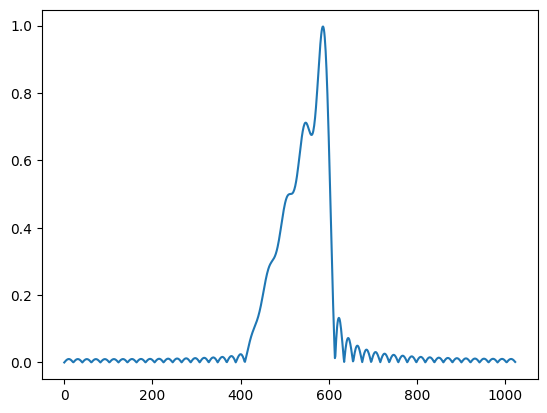

In [11]:
H_fft = np.fft.fftshift(np.abs(np.fft.fft(h, 1024)))
plt.plot(H_fft)
plt.show()

See how the frequency response not very straight… it doesn’t match our original very well, if you recall the shape that we initially wanted to make a filter for. A big reason is because our impulse response isn’t done decaying, i.e., the left and right sides don’t reach zero. We have two options that will allow it to decay to zero:

__Option 1:__ We “window” our current impulse response so that it decays to 0 on both sides. It involves multiplying our impulse response with a “windowing function” that starts and ends at zero.

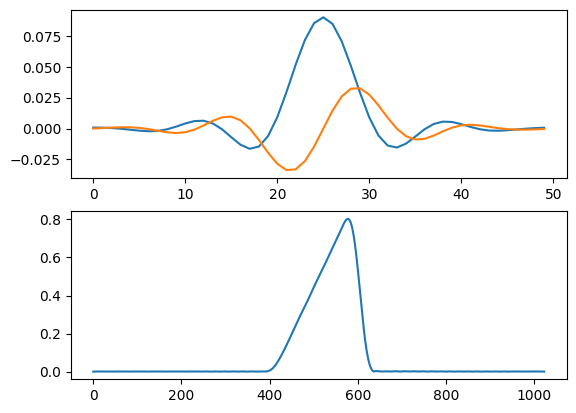

In [12]:
# After creating h using the previous code, create and apply the window
window = np.hamming(len(h))
h = h * window
H_fft = np.fft.fftshift(np.abs(np.fft.fft(h, 1024)))

fig, ax = plt.subplots(2,1)
ax[0].plot(np.real(h))
ax[0].plot(np.imag(h))
ax[1].plot(H_fft)
plt.show()

__Option 2:__ We re-generate our impulse response using more points so that it has time to decay. We need to add resolution to our original frequency domain array (called interpolating).

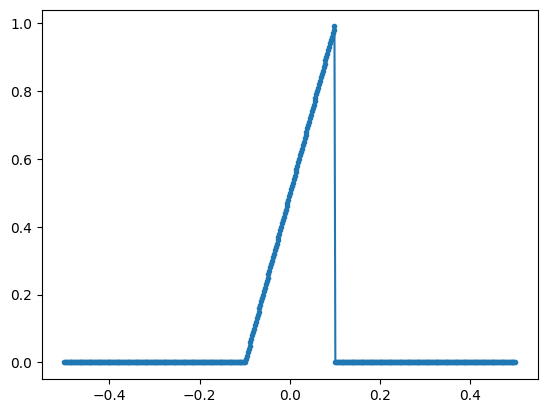

In [13]:
H = np.hstack((np.zeros(200), np.arange(0,1,0.01), np.zeros(200)))
w = np.linspace(-0.5, 0.5, 500)
plt.plot(w, H, '.-')
plt.show()
# (the rest of the code is the same)

![Alt text](https://pysdr.org/_images/filter_design6.png)

![Alt text](https://pysdr.org/_images/filter_design7.png)

Both options worked. Which one would you choose? The second method resulted in more taps, but the first method resulted in a frequency response that wasn’t very sharp and had a falling edge wasn’t very steep. There are numerous ways to design a filter, each with their own trade-offs along the way. Many consider filter design an art.